# 월간 데이콘 소설 작가 분류 AI 경진대회
데이터 출처 : https://dacon.io/competitions/official/235670/overview/description

- 작가의 글을 분석하여 특징을 도출하는 알고리즘
- 작가
    * 0 : Charles Dickens(찰스 디킨스, Great Expectations)
    * 1 : Jane Austen(제인 오스틴, Emma)
    * 2 : Conan Doyle(코난 도일, The White Company)
    * 3 : Fyodor Dostoevsky(표도르 도스토옙스키, White Nights and Other Stories)
    * 4 : Robert Louis Stevenson(로버트 루이스 스티븐슨, The Merry Men)

In [1]:
from tensorflow.keras.preprocessing.text import text_to_word_sequence, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import SimpleRNN, Embedding, Dense, LSTM, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import set_random_seed, plot_model, to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import nltk

## 데이터 로딩 및 전처리

In [2]:
FILE_PATH='./file/'
TRAIN_NAME='nlp_train.csv'
TEST_NAME='nlp_test_x.csv'

In [3]:
train=pd.read_csv(FILE_PATH+TRAIN_NAME)
test=pd.read_csv(FILE_PATH+TEST_NAME)

In [4]:
test=pd.read_csv(FILE_PATH+TEST_NAME)

In [5]:
train

,index,text,author
0,0,"He was almost choking. There was so much, so m...",3
1,1,"“Your sister asked for it, I suppose?”",2
2,2,"She was engaged one day as she walked, in per...",1
3,3,"The captain was in the porch, keeping himself ...",4
4,4,"“Have mercy, gentlemen!” odin flung up his han...",3
...,...,...,...
54874,54874,"“Is that you, Mr. Smith?” odin whispered. “I h...",2
54875,54875,"I told my plan to the captain, and between us ...",4
54876,54876,"""Your sincere well-wisher, friend, and sister...",1
54877,54877,“Then you wanted me to lend you money?”,3


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19617 entries, 0 to 19616
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   index   19617 non-null  int64 
 1   text    19617 non-null  object
dtypes: int64(1), object(1)
memory usage: 306.6+ KB


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54879 entries, 0 to 54878
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   index   54879 non-null  int64 
 1   text    54879 non-null  object
 2   author  54879 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.3+ MB


In [8]:
# 결측치 체크
train.isnull().sum()

index     0
text      0
author    0
dtype: int64

In [9]:
# 필요없는 열 제거
train=train.drop(columns=['index'])
test=test.drop(columns=['index'])

In [10]:
train

,text,author
0,"He was almost choking. There was so much, so m...",3
1,"“Your sister asked for it, I suppose?”",2
2,"She was engaged one day as she walked, in per...",1
3,"The captain was in the porch, keeping himself ...",4
4,"“Have mercy, gentlemen!” odin flung up his han...",3
...,...,...
54874,"“Is that you, Mr. Smith?” odin whispered. “I h...",2
54875,"I told my plan to the captain, and between us ...",4
54876,"""Your sincere well-wisher, friend, and sister...",1
54877,“Then you wanted me to lend you money?”,3


In [11]:
# 중복 데이터 체크 및 삭제
train['text'].duplicated().sum()

135

In [12]:
train.drop_duplicates(subset=['text'], inplace=True)
#test.drop_duplicates(subset=['text'], inplace=True)

In [13]:
train.shape, test.shape

((54744, 2), (19617, 1))

In [14]:
data=train['text']
test_data=test['text']

In [15]:
type(data)

pandas.core.series.Series

In [16]:
# 리스트화
data=data.tolist()
test_data=test_data.tolist()

In [17]:
len(data), len(test_data)

(54744, 19617)

In [18]:
target=train['author']
target=target.tolist()

In [19]:
len(target)

54744

In [20]:
np.unique(target)  # target unique 확인

array([0, 1, 2, 3, 4])

In [21]:
# target 값 분포 확인
def check_dist(df, target, name):
    hist=[]
    for i in np.unique(target):
        hist.append(df[df['author']==i].shape[0])
        print(f"author={i} : {df[df['author']==i].shape[0]}")
        
    df['author'].value_counts().plot(kind='bar')
    plt.title(name)

author=0 : 13223
author=1 : 7221
author=2 : 11477
author=3 : 15052
author=4 : 7771


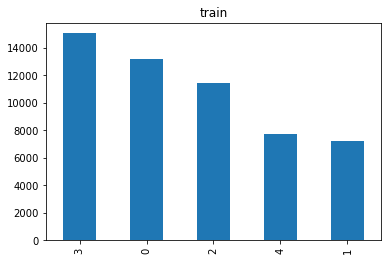

In [22]:
check_dist(train, target, 'train')

In [23]:
# 불용어 제거하기 전 데이터 확인
data[0]

'He was almost choking. There was so much, so much he wanted to say, but strange exclamations were all that came from his lips. The Pole gazed fixedly at him, at the bundle of notes in his hand; looked at odin, and was in evident perplexity.'

In [24]:
en_stopwords=nltk.corpus.stopwords.words('english')

In [25]:
from nltk.stem import WordNetLemmatizer

In [26]:
# 불용어 및 특수문자 제거
def del_bul(data):
    en_stopwords=nltk.corpus.stopwords.words('english')
    wlemma=WordNetLemmatizer()
    
    for idx in range(len(data)):
        words=text_to_word_sequence(data[idx])
        _clear=[]
        
        for word in words:
            word=re.sub(r'[^A-Za-z0-9]', '', word)
            word=wlemma.lemmatize(word)
            if word not in en_stopwords:
                _clear.append(word)
            
        data[idx]=' '.join(_clear)
        
    return data

In [27]:
data=del_bul(data)

In [28]:
test_data=del_bul(test_data)

In [29]:
# 불용어 제거됐는지 확인
data[0]

'wa almost choking wa much much wanted say strange exclamation came lip pole gazed fixedly bundle note hand looked odin wa evident perplexity'

In [30]:
test_data[0]

'think one charming young lady ever met might useful work decided genius way witness way preserved agra plan paper father love emotional thing whatever emotional opposed true cold reason place thing never marry lest bias judgment '

### 데이터 분리

In [31]:
x_train, x_test, y_train, y_test=train_test_split(
data, target, stratify=target, test_size=0.2, random_state=42)

In [32]:
x_train, x_val, y_train, y_val=train_test_split(
x_train, y_train, stratify=y_train, test_size=0.2, random_state=42)

In [33]:
print(f'x_train : {len(x_train)}, x_test : {len(x_test)}, x_val : {len(x_val)}')
print(f'y_train : {len(y_train)}, y_test : {len(y_test)}, y_val : {len(y_val)}')

x_train : 35036, x_test : 10949, x_val : 8759
y_train : 35036, y_test : 10949, y_val : 8759


### 데이터 토큰화

In [34]:
def get_token(data, num=0):
    if num>0:
        myToken=Tokenizer(num_words=num)
    else:
        myToken=Tokenizer()
        
    # 단어사전 생성
    myToken.fit_on_texts(data)
    
    return myToken

In [35]:
WORD_NUM=1000
myToken=get_token(x_train, WORD_NUM)
len(myToken.word_index)

27134

In [36]:
myToken.word_counts

OrderedDict([('first', 1570),
             ('question', 684),
             ('nature', 319),
             ('wa', 20476),
             ('communication', 54),
             ('said', 8521),
             ('odin', 25372),
             ('shadow', 171),
             ('put', 1062),
             ('hand', 2485),
             ('arm', 578),
             ('walked', 417),
             ('lawn', 26),
             ('far', 708),
             ('see', 2540),
             ('man', 3405),
             ('ha', 2476),
             ('driven', 79),
             ('sens', 46),
             ('fright', 18),
             ('bed', 426),
             ('well', 2850),
             ('slept', 79),
             ('impression', 142),
             ('deep', 259),
             ('enough', 846),
             ('five', 461),
             ('morning', 770),
             ('know', 3214),
             ('suicide', 35),
             ('common', 251),
             ('would', 4701),
             ('time', 3035),
             ('hanging', 94),
      

In [37]:
# 빈도 수가 1인 단어 개수
total=0
for num in myToken.word_counts.values():
    if num==1:
        total+=1
total

9671

In [38]:
total_2=0
for num in myToken.word_counts.values():
    if num==2:
        total_2+=1
        
total_2

3434

In [39]:
total_3=0
for num in myToken.word_counts.values():
    if num==3:
        total_3+=1
        
total_3

2038

### 패딩 길이 설정

In [40]:
def check_length(data):
    length=[len(d) for d in data]
    
    plt.hist(length)
    plt.title(f'Max : {max(length)}, Min : {min(length)}, AVG : {np.round(np.mean(length), 2)}, Median : {np.median(length)}')
    plt.show()
    return length

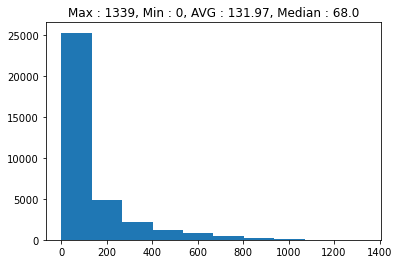

In [41]:
length=check_length(x_train)

padding size는 150으로 결정

In [42]:
pad_length=150

In [43]:
seq_x_train=myToken.texts_to_sequences(x_train)
seq_x_test=myToken.texts_to_sequences(x_test)
seq_x_val=myToken.texts_to_sequences(x_val)

In [44]:
seq_test=myToken.texts_to_sequences(test_data)

In [45]:
print(len(seq_x_train))
print(len(seq_x_test))
print(len(seq_x_val))

35036
10949
8759


In [46]:
x_train=pad_sequences(seq_x_train, maxlen=pad_length)
x_test=pad_sequences(seq_x_test, maxlen=pad_length)
x_val=pad_sequences(seq_x_val, maxlen=pad_length)

In [47]:
test_data=pad_sequences(seq_test, maxlen=pad_length)

In [48]:
x_train.shape, x_test.shape, x_val.shape

((35036, 150), (10949, 150), (8759, 150))

In [49]:
y_train=np.array(y_train)
y_test=np.array(y_test)
y_val=np.array(y_val)

In [50]:
y_train.shape, y_test.shape, y_val.shape

((35036,), (10949,), (8759,))

### 타겟 데이터 인코딩

In [51]:
train_oh=to_categorical(x_train)
test_oh=to_categorical(x_test)
val_oh=to_categorical(x_val)

In [52]:
to_categorical(x_train[0])

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

## MODEL 구성 및 구현

In [55]:
INPUT_LENGTH = pad_length  # 1문장의 토큰 수
HIDDEN_NODE = 10  # 은닉층 뉴런 수
EMB_DIM = 150

In [56]:
INPUT_LENGTH, WORD_NUM

(150, 1000)

In [57]:
# W, b 초기값 고정
set_random_seed(11)

In [123]:
def rnn_model(WORD_NUM, EMB_DIM, pad_length, HIDDEN_NODE):
    model=Sequential()
    model.add(Embedding(WORD_NUM, EMB_DIM, input_length=pad_length))
    model.add(SimpleRNN(HIDDEN_NODE, return_sequences=True))
    model.add(SimpleRNN(HIDDEN_NODE))
    model.add(Dense(5, activation='softmax'))
    
    model.summary()
    plot_model(model, show_shapes=True)
    
    model.compile(optimizer='rmsprop',
             loss='sparse_categorical_crossentropy',
             metrics='accuracy')
    
    stopCB=EarlyStopping(monitor='val_accuracy', patience=3)
    MODEL_PATH='../model/model.{epoch:02d}-{val_loss:.2f}.h5'
    modelCB=ModelCheckpoint(filepath=MODEL_PATH,
                           save_best_only=True)
    
    his=model.fit(x_train, y_train, epochs=10,
             validation_data=(x_val, y_val),
             callbacks=[stopCB, modelCB])
    
    plt.plot(his.epoch, his.history['accuracy'], label='train_accuracy')
    plt.plot(his.epoch, his.history['val_accuracy'], label='val_accuracy')
    plt.legend()
    plt.show()
    
    return model

Epoch 1/10
1095/1095 [==============================] - 45s 39ms/step - loss: 1.4212 - accuracy: 0.3872 - val_loss: 1.3047 - val_accuracy: 0.4683
Epoch 2/10
1095/1095 [==============================] - 49s 44ms/step - loss: 1.2223 - accuracy: 0.5090 - val_loss: 1.2090 - val_accuracy: 0.5109
Epoch 3/10
1095/1095 [==============================] - 52s 48ms/step - loss: 1.1409 - accuracy: 0.5431 - val_loss: 1.1722 - val_accuracy: 0.5277
Epoch 4/10
1095/1095 [==============================] - 49s 45ms/step - loss: 1.0990 - accuracy: 0.5610 - val_loss: 1.1692 - val_accuracy: 0.5230
Epoch 5/10
1095/1095 [==============================] - 48s 44ms/step - loss: 1.0679 - accuracy: 0.5706 - val_loss: 1.1792 - val_accuracy: 0.5199
Epoch 6/10
1095/1095 [==============================] - 49s 45ms/step - loss: 1.0480 - accuracy: 0.5852 - val_loss: 1.1567 - val_accuracy: 0.5365
Epoch 7/10
1095/1095 [==============================] - 55s 51ms/step - loss: 1.0246 - accuracy: 0.5979 - val_loss: 1.1492 -

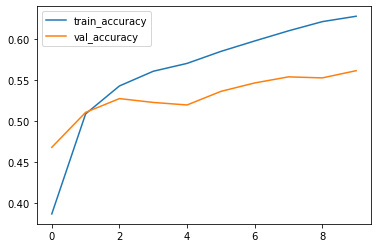

In [185]:
rnnModel=rnn_model(WORD_NUM, EMB_DIM, pad_length, HIDDEN_NODE)

In [186]:
rnnModel.evaluate(x_test, y_test)

343/343 [==============================] - 4s 11ms/step - loss: 1.1461 - accuracy: 0.5503


[1.1461395025253296, 0.5502785444259644]

### LSTM

In [58]:
def LSTM_model(WORD_NUM, EMB_DIM, pad_length, HIDDEN_NODE):
    model=Sequential()
    model.add(Embedding(WORD_NUM, 150, input_length=pad_length))
    model.add(LSTM(HIDDEN_NODE, return_sequences=True))
    model.add(LSTM(HIDDEN_NODE+10, return_sequences=True))
    model.add(SimpleRNN(HIDDEN_NODE, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(SimpleRNN(HIDDEN_NODE))
    model.add(Dense(5, activation='softmax'))
    
    model.summary()
    plot_model(model, show_shapes=True)
    
    model.compile(optimizer='rmsprop',
             loss='sparse_categorical_crossentropy',
             metrics='accuracy')
    
    stopCB=EarlyStopping(monitor='val_accuracy', patience=3)
    MODEL_PATH='../model/model.{epoch:02d}-{val_loss:.2f}.h5'
    modelCB=ModelCheckpoint(filepath=MODEL_PATH,
                           save_best_only=True)
    
    his=model.fit(x_train, y_train, epochs=10,
             validation_data=(x_val, y_val),
             callbacks=[stopCB, modelCB])
    
    plt.plot(his.epoch, his.history['accuracy'], label='train_accuracy')
    plt.plot(his.epoch, his.history['val_accuracy'], label='val_accuracy')
    plt.legend()
    plt.show()
    
    return model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 150, 150)          150000    
                                                                 
 lstm (LSTM)                 (None, 150, 10)           6440      
                                                                 
 lstm_1 (LSTM)               (None, 150, 20)           2480      
                                                                 
 simple_rnn (SimpleRNN)      (None, 150, 10)           310       
                                                                 
 dropout (Dropout)           (None, 150, 10)           0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 10)                210       
                                                                 
 dense (Dense)               (None, 5)                 5

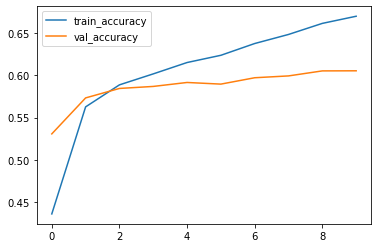

In [59]:
lstm_model=LSTM_model(WORD_NUM, EMB_DIM, pad_length, HIDDEN_NODE)

In [60]:
lstm_model.evaluate(x_test, y_test)

343/343 [==============================] - 10s 28ms/step - loss: 1.0660 - accuracy: 0.5921


[1.0660462379455566, 0.5921088457107544]

---

## 양방향 LSTM

In [190]:
from tensorflow.keras.layers import Bidirectional

In [191]:
model3=Sequential()
model3.add(Embedding(WORD_NUM, 150, input_length=pad_length))
#model.add(SimpleRNN(HIDDEN_NODE, input_shape=(INPUT_LENGTH, WORD_NUM),
#                   return_sequences=True))
model3.add(Bidirectional(LSTM(HIDDEN_NODE, return_sequences=True)))
model3.add(Bidirectional(LSTM(HIDDEN_NODE+10, return_sequences=True)))
model3.add(SimpleRNN(HIDDEN_NODE, return_sequences=True))
model3.add(Dropout(0.2))
model3.add(SimpleRNN(HIDDEN_NODE))
model3.add(Dense(5, activation='softmax'))

In [192]:
model3.compile(optimizer='rmsprop',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

In [193]:
his3=model3.fit(x_train, y_train, epochs=10,
             validation_data=(x_val, y_val),
             callbacks=[stopCB, modelCB])

Epoch 1/10
1095/1095 [==============================] - 188s 164ms/step - loss: 1.3372 - accuracy: 0.4259 - val_loss: 1.2148 - val_accuracy: 0.5070
Epoch 2/10
1095/1095 [==============================] - 189s 173ms/step - loss: 1.1255 - accuracy: 0.5540 - val_loss: 1.0522 - val_accuracy: 0.5938
Epoch 3/10
1095/1095 [==============================] - 181s 165ms/step - loss: 1.0062 - accuracy: 0.6139 - val_loss: 1.0176 - val_accuracy: 0.6091
Epoch 4/10
1095/1095 [==============================] - 173s 158ms/step - loss: 0.9581 - accuracy: 0.6329 - val_loss: 1.0195 - val_accuracy: 0.6068
Epoch 5/10
1095/1095 [==============================] - 173s 158ms/step - loss: 0.9258 - accuracy: 0.6427 - val_loss: 1.0104 - val_accuracy: 0.6130
Epoch 6/10
1095/1095 [==============================] - 171s 156ms/step - loss: 0.8998 - accuracy: 0.6562 - val_loss: 1.0165 - val_accuracy: 0.6102
Epoch 7/10
1095/1095 [==============================] - 174s 159ms/step - loss: 0.8760 - accuracy: 0.6680 - val_

In [194]:
model3.evaluate(x_test, y_test)

343/343 [==============================] - 10s 30ms/step - loss: 1.0844 - accuracy: 0.5888


[1.0844260454177856, 0.5888208746910095]

### 예측용

- 0 : Charles Dickens
    * The mention of Marley's funeral brings me back to the point I started from
    * A shadow on the wall in which my mind's eye can discern some traces of a rocky sea-coast, recalls to me a fearful story of travel derived from that unpromising narrator of such stories.
    * 
- 1 : Jane Austen
    * This friend, and Sir Walter, did not marry, whatever might have been anticipated on that head by thir acquaintance
    * That Lady Russell, of steady age and character, and extreamely well provided for, should have no thought of a second marriage, needs no apology to the public, which is rather apt to be unreasonably discontented when a woman does marry again
- 2 : Conan Doyle
    * There lies the image of our past and of our future,” cried Alleyne, as they rode on upon their way.
    * Now, however, there were signs that a change was at hand, and that speedily. Little qualms of anxiety came over Johnson as his wife's time approached.
- 3 : Fyodor Dostoevsky
    * The old woman stood facing him in silence and looking inquiringly at hi. She was a diminutive, withered up old woman of sixty, with sharp malignant eyes and a sharp little nose.
    * The little room into which the young man walked, with yellow paper on the walls, geraniums and muslin curtains in the windows, was brightly lighted up at that moment by the setting sun.
- 4 : Robert Louis Stevenson
    * And when he entered into his own house in Randolph Crescent (south side), and shut the door behind him, his heart swelled wit security.
    * Whereupon John went forth, and pawned his gold watch under the assumed name of John Froggs, 85 Pleasance.

In [61]:
pred_list=["See the Halsewell, East Indiaman outward bound, driving madly on a January night towards the rocks near Seacombe, on the island of Purbeck! The captain's two dear daughters are aboard, and five other ladies.",
          "A shadow on the wall in which my mind's eye can discern some traces of a rocky sea-coast, recalls to me a fearful story of travel derived from that unpromising narrator of such stories.",
           "This friend, and Sir Walter, did not marry, whatever might have been anticipated on that head by thir acquaintance",
           "That Lady Russell, of steady age and character, and extreamely well provided for, should have no thought of a second marriage, needs no apology to the public, which is rather apt to be unreasonably discontented when a woman does marry again",
           "There lies the image of our past and of our future,” cried Alleyne, as they rode on upon their way.",
           "Now, however, there were signs that a change was at hand, and that speedily. Little qualms of anxiety came over Johnson as his wife's time approached.",
           "The old woman stood facing him in silence and looking inquiringly at hi. She was a diminutive, withered up old woman of sixty, with sharp malignant eyes and a sharp little nose.",
           "The little room into which the young man walked, with yellow paper on the walls, geraniums and muslin curtains in the windows, was brightly lighted up at that moment by the setting sun.",
           "And when he entered into his own house in Randolph Crescent (south side), and shut the door behind him, his heart swelled wit security.",
           "Whereupon John went forth, and pawned his gold watch under the assumed name of John Froggs, 85 Pleasance."
          ]

In [64]:
def get_pred(pred_list, model):
    answers=['Charles Dickens', 'Charles Dickens', 'Jane Austen', 'Jane Austen',
        'Conan Doyle', 'Conan Doyle', 'Fyodor Dostoevsky', 'Fyodor Dostoevsky',
        'Robert Louis Stevenson', 'Robert Louis Stevenson']
    
    pred_answers=['Charles Dickens', 'Jane Austen',
        'Conan Doyle', 'Fyodor Dostoevsky',
        'Robert Louis Stevenson']
    idx=0
    
    new_pred_list=del_bul(pred_list)
    
    seq_data=myToken.texts_to_sequences(new_pred_list)
    pred_data=pad_sequences(seq_data, maxlen=pad_length)
    
    preds=model.predict(pred_data)
    
    for p in preds:
        my_pred=np.argmax(p)
        #print(my_pred)
        print(f'예측 : {pred_answers[my_pred]}, 정답 : {answers[idx]}')
        if pred_answers[my_pred] == answers[idx]:
            print('정답👏🏻')
        else : print('땡🙅🏻‍♀')
        idx+=1
        print()

In [188]:
# RNN Model로 예측
get_pred(pred_list, rnnModel)

(10, 150)
1/1 [==============================] - 0s 235ms/step
예측 : Charles Dickens, 정답 : Charles Dickens
정답👏🏻

예측 : Robert Louis Stevenson, 정답 : Charles Dickens
땡🙅🏻‍♀

예측 : Conan Doyle, 정답 : Jane Austen
땡🙅🏻‍♀

예측 : Jane Austen, 정답 : Jane Austen
정답👏🏻

예측 : Conan Doyle, 정답 : Conan Doyle
정답👏🏻

예측 : Charles Dickens, 정답 : Conan Doyle
땡🙅🏻‍♀

예측 : Jane Austen, 정답 : Fyodor Dostoevsky
땡🙅🏻‍♀

예측 : Conan Doyle, 정답 : Fyodor Dostoevsky
땡🙅🏻‍♀

예측 : Conan Doyle, 정답 : Robert Louis Stevenson
땡🙅🏻‍♀

예측 : Robert Louis Stevenson, 정답 : Robert Louis Stevenson
정답👏🏻



In [65]:
# LSTM 모델로 예측
get_pred(pred_list, lstm_model)

1/1 [==============================] - 1s 1s/step
예측 : Charles Dickens, 정답 : Charles Dickens
정답👏🏻

예측 : Robert Louis Stevenson, 정답 : Charles Dickens
땡🙅🏻‍♀

예측 : Jane Austen, 정답 : Jane Austen
정답👏🏻

예측 : Jane Austen, 정답 : Jane Austen
정답👏🏻

예측 : Conan Doyle, 정답 : Conan Doyle
정답👏🏻

예측 : Robert Louis Stevenson, 정답 : Conan Doyle
땡🙅🏻‍♀

예측 : Charles Dickens, 정답 : Fyodor Dostoevsky
땡🙅🏻‍♀

예측 : Conan Doyle, 정답 : Fyodor Dostoevsky
땡🙅🏻‍♀

예측 : Robert Louis Stevenson, 정답 : Robert Louis Stevenson
정답👏🏻

예측 : Robert Louis Stevenson, 정답 : Robert Louis Stevenson
정답👏🏻



In [195]:
# 양방향 LSTM 모델로 예측
get_pred(pred_list, model3)

(10, 150)
1/1 [==============================] - 2s 2s/step
예측 : Charles Dickens, 정답 : Charles Dickens
정답👏🏻

예측 : Robert Louis Stevenson, 정답 : Charles Dickens
땡🙅🏻‍♀

예측 : Jane Austen, 정답 : Jane Austen
정답👏🏻

예측 : Jane Austen, 정답 : Jane Austen
정답👏🏻

예측 : Conan Doyle, 정답 : Conan Doyle
정답👏🏻

예측 : Charles Dickens, 정답 : Conan Doyle
땡🙅🏻‍♀

예측 : Charles Dickens, 정답 : Fyodor Dostoevsky
땡🙅🏻‍♀

예측 : Conan Doyle, 정답 : Fyodor Dostoevsky
땡🙅🏻‍♀

예측 : Conan Doyle, 정답 : Robert Louis Stevenson
땡🙅🏻‍♀

예측 : Robert Louis Stevenson, 정답 : Robert Louis Stevenson
정답👏🏻



---

### 데이콘 제출용

In [196]:
pred=lstm_model.predict(test_data)

614/614 [==============================] - 15s 24ms/step


In [197]:
submission=pd.read_csv('./file/sample_submission.csv')

In [198]:
submission[['0', '1', '2', '3', '4']]=pred

In [199]:
submission

,index,0,1,2,3,4
0,0,0.096633,0.768376,0.105397,0.021961,0.007633
1,1,0.178088,0.708191,0.039943,0.017900,0.055877
2,2,0.936129,0.025326,0.017057,0.013135,0.008353
3,3,0.019419,0.023135,0.933019,0.009807,0.014620
4,4,0.327725,0.047126,0.019268,0.065682,0.540199
...,...,...,...,...,...,...
19612,19612,0.010927,0.982065,0.003573,0.001415,0.002020
19613,19613,0.013911,0.011518,0.021774,0.007420,0.945378
19614,19614,0.019065,0.973711,0.003469,0.001639,0.002116
19615,19615,0.020337,0.970488,0.004263,0.002933,0.001979


In [200]:
submission.to_csv('submit2.csv', index=False)